### Imports

In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np
import struct
import time
from decimal import Decimal
from concurrent.futures import ProcessPoolExecutor, as_completed

### Function Definitions

In [2]:
def float_to_binary_str(f):
    # Pack the float into 4 bytes (32-bit) using IEEE 754 standard
    [packed] = struct.unpack('!I', struct.pack('!f', f))
    # Convert the packed number to a binary string
    return f"{packed:032b}"

In [3]:
def HW_float32(f):
    # Get the binary representation of the 32-bit float
    binary_str = float_to_binary_str(f)
    # Count and return the number of '1' bits
    return binary_str.count('1')

In [4]:
def get_weights_arr():
    weights_arr = []
    w_val = Decimal('-2.0')
    step = Decimal('0.01')
    for i in range (401):
        weights_arr.append(float(w_val))
        w_val += step
    return weights_arr

In [5]:
print(float_to_binary_str(0.657))
print(HW_float32(0.657))

00111111001010000011000100100111
15


In [6]:
def wrapped_CPA_attack(trace_waves, inputs, weights, time_sample_index):
    result = CPA_attack(trace_waves, inputs, weights, time_sample_index)
    return result, time_sample_index

In [7]:
def CPA_attack(trace_waves, inputs, weights, time_sample_index):
    r_abs = []
    n_trace_waves = len(trace_waves)
    leakage_sum = 0
    for trace_wave in trace_waves:
        leakage_sum += trace_wave[time_sample_index]    
    average_leakage = leakage_sum / n_trace_waves
    M = len(inputs)
    N = len(weights)
    
    for i in range(N):
        hypothetical_products = []
        hypothetical_leakages = []
        hypothetical_leakage_sum = 0
        for j in range(M):
            hypothetical_product = weights[i] * inputs[j]
            hypothetical_products.append(hypothetical_product)
            hypothetical_leakage = HW_float32(hypothetical_product)
            hypothetical_leakages.append(hypothetical_leakage)
            hypothetical_leakage_sum += hypothetical_leakage
            
        average_hypothetical_leakage = hypothetical_leakage_sum / M        
        
        numerator= 0
        denominator1 = 0
        denominator2 = 0
        for j in range(M):
            numerator += (hypothetical_leakages[j] - average_hypothetical_leakage) * (trace_waves[j][time_sample_index] - average_leakage)
            denominator1 += (hypothetical_leakages[j] - average_hypothetical_leakage)**2
            denominator2 += (trace_waves[j][time_sample_index] - average_leakage)**2
            #print(f'Input {inputs[j]} with idx {j}, weight {weights[i]} with idx {i} -> hypothetical_product = {hypothetical_products[j]}' +
            #     f' hypothetical_leakage = {hypothetical_leakages[j]}')
        denominator1 = denominator1**(1/2)
        denominator2 = denominator2**(1/2)
        #print(numerator, denominator1, denominator2)
        
        corr_coef = numerator / (denominator1 * denominator2)
        r_abs.append(abs(corr_coef))
    return r_abs
        
            
            
            

### Project Setup

In [8]:
proj = cw.open_project('project-06')

In [9]:
trace_waves_arr = []
inputs_arr = []
for trace in proj.traces:
    trace_waves_arr.append(trace.wave)
    inputs_arr.append(trace.textin)
print(len(trace_waves_arr))
print(len(inputs_arr))

2000
2000


#### Test inputs 

In [10]:

test_inputs = [0.5, 0.657, 0.3333, 0.0003, 0.189, 0.5243, 0.2222, 0.4959]
test_trace_waves = trace_waves_arr[:8]
test_weights = [0.21, 0.22, 0.23]
test_time_sample_index = 5

In [11]:
CPA_attack(trace_waves = test_trace_waves,
           inputs = test_inputs,
           weights = test_weights,
           time_sample_index = test_time_sample_index)

[0.08799967855586352, 0.23679642799106917, 0.5480060249106488]

#### Generating a weight array - allways the same

In [12]:
weights_arr = []
w_val = Decimal('-2.0')
step = Decimal('0.01')
for i in range (401):
    weights_arr.append(float(w_val))
    w_val += step
print(weights_arr)


[-2.0, -1.99, -1.98, -1.97, -1.96, -1.95, -1.94, -1.93, -1.92, -1.91, -1.9, -1.89, -1.88, -1.87, -1.86, -1.85, -1.84, -1.83, -1.82, -1.81, -1.8, -1.79, -1.78, -1.77, -1.76, -1.75, -1.74, -1.73, -1.72, -1.71, -1.7, -1.69, -1.68, -1.67, -1.66, -1.65, -1.64, -1.63, -1.62, -1.61, -1.6, -1.59, -1.58, -1.57, -1.56, -1.55, -1.54, -1.53, -1.52, -1.51, -1.5, -1.49, -1.48, -1.47, -1.46, -1.45, -1.44, -1.43, -1.42, -1.41, -1.4, -1.39, -1.38, -1.37, -1.36, -1.35, -1.34, -1.33, -1.32, -1.31, -1.3, -1.29, -1.28, -1.27, -1.26, -1.25, -1.24, -1.23, -1.22, -1.21, -1.2, -1.19, -1.18, -1.17, -1.16, -1.15, -1.14, -1.13, -1.12, -1.11, -1.1, -1.09, -1.08, -1.07, -1.06, -1.05, -1.04, -1.03, -1.02, -1.01, -1.0, -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92, -0.91, -0.9, -0.89, -0.88, -0.87, -0.86, -0.85, -0.84, -0.83, -0.82, -0.81, -0.8, -0.79, -0.78, -0.77, -0.76, -0.75, -0.74, -0.73, -0.72, -0.71, -0.7, -0.69, -0.68, -0.67, -0.66, -0.65, -0.64, -0.63, -0.62, -0.61, -0.6, -0.59, -0.58, -0.57, -0.56,

In [13]:
CPA_attack(trace_waves = trace_waves_arr,
           inputs = inputs_arr,
           weights = weights_arr,
           time_sample_index = 1)

[0.14363074231495296,
 0.021314037311415648,
 0.022032151757364823,
 0.030037239404168636,
 0.015032801857995208,
 0.009294187723480746,
 0.018993495351944095,
 0.006769962579041124,
 0.020545360130552144,
 0.030539164904880404,
 0.016533300568582914,
 0.012589224070304885,
 0.016371335705602782,
 0.0068442126346084315,
 0.028214427520304737,
 0.014748050893643257,
 0.010161375653263563,
 0.01885136669127515,
 0.017671721221972136,
 0.016395184651726895,
 0.04493411707204438,
 0.0015609462016217684,
 0.0022335190882233485,
 0.018309006749693227,
 0.006387354834174631,
 0.01677737096508561,
 0.005995590521807647,
 0.0163848442389738,
 0.021606022002382198,
 0.029512512433350988,
 0.009792722364225194,
 0.021771495072824706,
 0.007733091282346574,
 0.04272443265624495,
 0.008380759975599339,
 0.02818021629315738,
 0.02440439716699824,
 0.01963064638749918,
 0.02971954316765434,
 0.018767842189079516,
 0.04694623532384933,
 0.02894708642535457,
 0.00030505255792329263,
 0.0158147647810972

In [ ]:
start = time.time()
r_abs_all_time_samples = []
start_time_sample = 400
n_time_samples = 10
completed_counter = 0


num_threads = 8
with ProcessPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(wrapped_CPA_attack, trace_waves_arr, inputs_arr, weights_arr, i) for i in range(start_time_sample, start_time_sample + n_time_samples)]
    
    results = [None] * (n_time_samples)
    
    for future in as_completed(futures):
        try:
            result, i = future.result()
            results[i - start_time_sample] = result
            completed_counter += 1
            print(f"{completed_counter} time samples completed")
        except Exception as e:
            print(f"Error during computation: {e}")
        
r_abs_all_time_samples.extend(results)
        
end = time.time()
print(f'Time elapsed: {end - start}')
print(len(r_abs_all_time_samples))

Error during computation: A process in the process pool was terminated abruptly while the future was running or pending.
A process in the process pool was terminated abruptly while the future was running or pending.
Error during computation: A process in the process pool was terminated abruptly while the future was running or pending.
A process in the process pool was terminated abruptly while the future was running or pending.
Error during computation: A process in the process pool was terminated abruptly while the future was running or pending.
A process in the process pool was terminated abruptly while the future was running or pending.
Error during computation: A process in the process pool was terminated abruptly while the future was running or pending.
A process in the process pool was terminated abruptly while the future was running or pending.
Error during computation: A process in the process pool was terminated abruptly while the future was running or pending.
A process in th

In [15]:
start = time.time()
r_abs_all_time_samples = []
start_time_sample = 400
n_time_samples = 4
for i in range(start_time_sample, start_time_sample + n_time_samples):
    r_abs_all_time_samples.append(CPA_attack(trace_waves = trace_waves_arr,
           inputs = inputs_arr,
           weights = weights_arr,
           time_sample_index = i))
    if ((i - start_time_sample + 1) % 100 == 0):
        print(f"{(i - start_time_sample) + 1} timesamlpes done! {time.time() - start} seconds elapsed!")
        
end = time.time()
print(f'Time elapsed: {end - start}')
print(len(r_abs_all_time_samples))

Time elapsed: 18.776531219482422
4


In [21]:
corr_graphs = []

for i in range(len(weights_arr)):
    corr_graph = []
    for u in range(4000):
        corr_graph.append(r_abs_all_time_samples[u][i])
    corr_graphs.append(corr_graph)

In [25]:
max_corr = 0
max_corr_index = 0
for i in range(len(corr_graphs)):
    if (max(corr_graphs[i]) > max_corr and i!=200):
        max_corr = max(corr_graphs[i])
        max_corr_index = i

print(max_corr_index)
print(max_corr)

212
0.8396905035125037


In [26]:
print(weights_arr[max_corr_index])

0.12


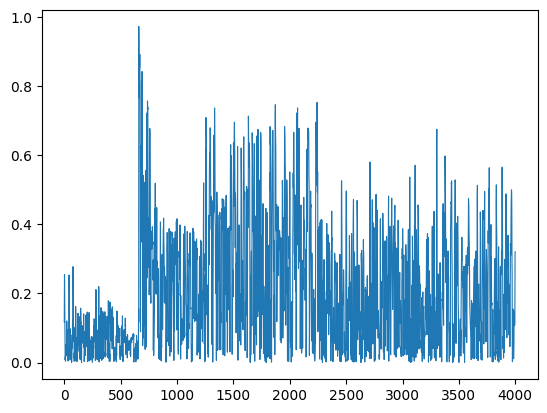

In [33]:
plt.plot(corr_graphs[200], linewidth=0.8)
#plt.savefig('max_corr_graph_w200.svg', format='svg')
plt.show()


In [28]:
np_corr_graphs = np.array(corr_graphs)
np_r_abs_all_time_samples = np.array(r_abs_all_time_samples)

In [29]:
np.save('np_corr_graphs_1000i_401w_4000ts.npy', np_corr_graphs)
np.save('np_r_abs_all_time_samples_1000i_401w_4000ts.npy', np_r_abs_all_time_samples)

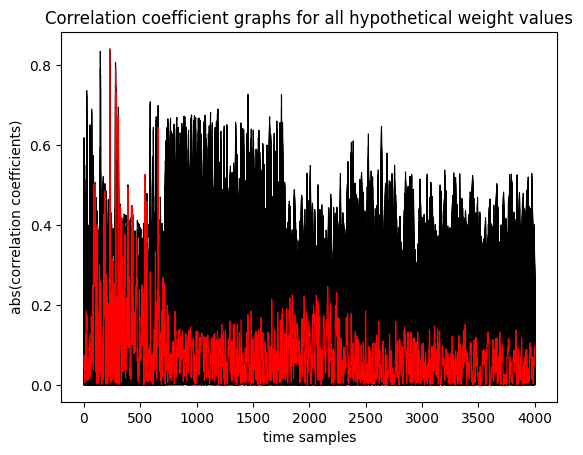

In [42]:
for i in range(len(weights_arr)):
    if weights_arr[i] != 0.0:
        plt.plot(corr_graphs[i], linewidth=0.8, color='black')
plt.plot(corr_graphs[max_corr_index], linewidth=0.8, color='red')
plt.xlabel('time samples')
plt.ylabel('abs(correlation coefficients)')
plt.title('Correlation coefficient graphs for all hypothetical weight values')
#plt.savefig('max_corr_graphs_w0excluded.svg', format='svg')
plt.show()